<a href="https://colab.research.google.com/github/Shubhammehta2005/ECE501_2025_8_Pixels/blob/main/Codes/LSB_and_DWT_method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **LSB METHOD**

✅ Watermark embedded successfully!
✅ Watermark extracted successfully!


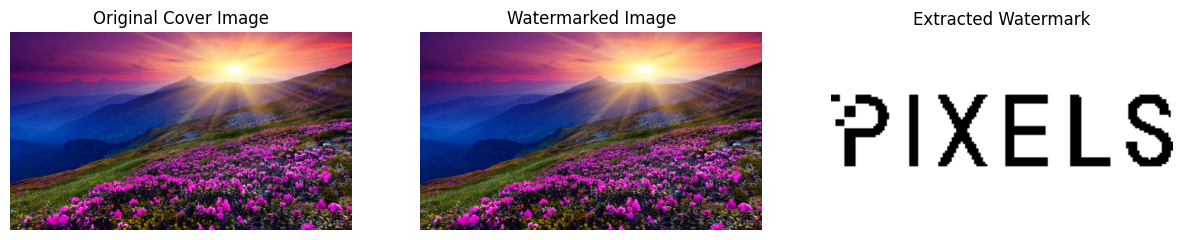

In [ ]:
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt

# ---------------- CONFIG ----------------
cover_image_path = "cover.png"        # your cover image file in Colab
watermark_image_path = "watermark.png"  # your watermark image file
secret_key = 12345
# ---------------------------------------

# Load images
cover = cv2.imread(cover_image_path)
watermark = cv2.imread(watermark_image_path, cv2.IMREAD_GRAYSCALE)

if cover is None or watermark is None:
    raise Exception("❌ Could not read one or both images. Check file paths.")

# Resize watermark (¼ size of cover for safety)
wm_resized = cv2.resize(watermark, (cover.shape[1]//4, cover.shape[0]//4))
_, wm_bin = cv2.threshold(wm_resized, 127, 1, cv2.THRESH_BINARY)

# Flatten watermark bits
wm_bits = wm_bin.flatten().astype(np.uint8)
total_bits = len(wm_bits)

# Flatten cover and ensure it's uint8
flat_cover = cover.flatten().astype(np.uint8)

# Generate random pixel positions using secret key
random.seed(secret_key)
indices = random.sample(range(len(flat_cover)), total_bits)

# Embed watermark bits into LSBs safely
for i, bit in enumerate(wm_bits):
    pixel_value = int(flat_cover[indices[i]])
    pixel_value = (pixel_value & ~1) | int(bit)
    flat_cover[indices[i]] = np.uint8(pixel_value)

# Reshape back into image
watermarked = flat_cover.reshape(cover.shape)
print("✅ Watermark embedded successfully!")

# ---------------- EXTRACT WATERMARK ----------------
flat_received = watermarked.flatten().astype(np.uint8)

# Extract bits using same secret key
extracted_bits = np.array([(flat_received[idx] & 1) for idx in indices], dtype=np.uint8)
extracted_image = extracted_bits.reshape(wm_bin.shape) * 255

print("✅ Watermark extracted successfully!")

# ---------------- SHOW RESULTS ----------------
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title("Original Cover Image")
plt.imshow(cv2.cvtColor(cover, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1,3,2)
plt.title("Watermarked Image")
plt.imshow(cv2.cvtColor(watermarked, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1,3,3)
plt.title("Extracted Watermark")
plt.imshow(extracted_image, cmap='gray')
plt.axis('off')

plt.show()


# **DWT INDIVIDUAL**

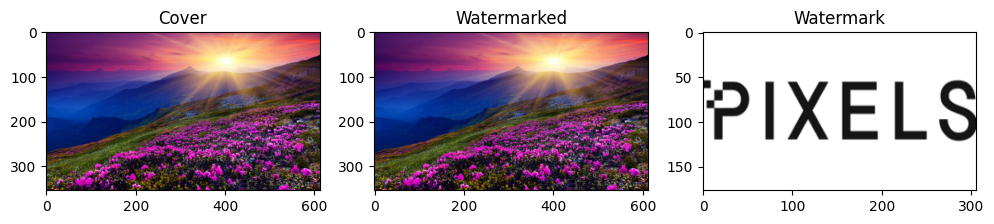

In [ ]:
import cv2
import numpy as np
import pywt
import matplotlib.pyplot as plt

# --- Load images ---
cover = cv2.imread('cover.png')  # RGB cover image
watermark = cv2.imread('watermark.png', cv2.IMREAD_GRAYSCALE)  # grayscale watermark

# Resize watermark to half the size of cover
rows, cols, _ = cover.shape
watermark = cv2.resize(watermark, (cols//2, rows//2))
watermark = watermark / 255.0  # normalize 0-1

# Split cover into RGB channels
B, G, R = cv2.split(cover)
alpha = 5  # embedding strength

def embed_watermark(channel, watermark, alpha):
    LL, (LH, HL, HH) = pywt.dwt2(channel, 'haar')
    LH_watermarked = LH + alpha * watermark
    channel_watermarked = pywt.idwt2((LL, (LH_watermarked, HL, HH)), 'haar')
    return np.clip(channel_watermarked, 0, 255).astype(np.uint8)

# Embed in each channel (or choose one channel)
R_w = embed_watermark(R, watermark, alpha)
G_w = embed_watermark(G, watermark, alpha)
B_w = embed_watermark(B, watermark, alpha)

# Merge channels
watermarked_image = cv2.merge([B_w, G_w, R_w])

# Save watermarked image
cv2.imwrite('watermarked_image.png', watermarked_image)

# Display
plt.figure(figsize=(12,5))
plt.subplot(1,3,1); plt.title('Cover'); plt.imshow(cv2.cvtColor(cover, cv2.COLOR_BGR2RGB))
plt.subplot(1,3,2); plt.title('Watermarked'); plt.imshow(cv2.cvtColor(watermarked_image, cv2.COLOR_BGR2RGB))
plt.subplot(1,3,3); plt.title('Watermark'); plt.imshow(watermark, cmap='gray')
plt.show()


In [ ]:
cv2.imwrite('watermarked.png', watermarked_image)

True

# **EXTRACTION BY DWT METHOD**

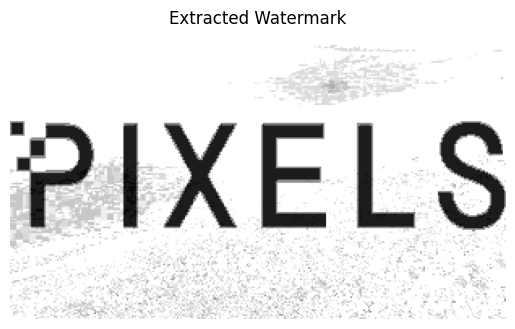

In [ ]:
# Split channels
B_c, G_c, R_c = cv2.split(cover)
B_w, G_w, R_w = cv2.split(watermarked_image)

def extract_watermark(channel_cover, channel_watermarked, alpha, size):
    LL_c, (LH_c, HL_c, HH_c) = pywt.dwt2(channel_cover, 'haar')
    LL_w, (LH_w, HL_w, HH_w) = pywt.dwt2(channel_watermarked, 'haar')

    watermark_extracted = (LH_w - LH_c) / alpha
    watermark_extracted = np.clip(watermark_extracted, 0, 1)

    watermark_extracted = cv2.resize(watermark_extracted, size)
    return watermark_extracted

# Extract from each channel
watermark_rows, watermark_cols = watermark.shape
R_wm = extract_watermark(R_c, R_w, alpha, (watermark_cols, watermark_rows))
G_wm = extract_watermark(G_c, G_w, alpha, (watermark_cols, watermark_rows))
B_wm = extract_watermark(B_c, B_w, alpha, (watermark_cols, watermark_rows))

# Average channels to get final watermark
watermark_final = (R_wm + G_wm + B_wm) / 3

# Display extracted watermark
plt.imshow(watermark_final, cmap='gray')
plt.title('Extracted Watermark')
plt.axis('off')
plt.show()
